Here we train the convolutional neural network with hyperparameter tuning.

What we first do is filter the data into training, test and validation sets. 

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import PIL
import seaborn as sns
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We filter the data into train/val/test in ratio 80|10|10.

In [5]:
labeling = pd.read_csv('./labels_upsampled.csv')
labeling

,filename,item_type,label
0,100_i110.png,100,plastic
1,100_i120.png,100,plastic
2,100_i130.png,100,plastic
3,100_i140.png,100,plastic
4,100_i150.png,100,plastic
...,...,...,...
19639,327_i140_aug_x1995.png,327,"wood,paper"
19640,364_i180_aug_x1996.png,364,"wood,paper"
19641,219_i160_aug1430_aug_x1997.png,219,"wood,paper"
19642,878_i250_aug2203_aug_x1998.png,878,"wood,paper"


In [6]:
source_dir = './DataFilteredPlural/'
target_dir = './trainvaltest/'

Training via Convolutional Neural Network:
But first we need to load the data into dataloaders

In [7]:
#frequency of each class in train/val/test
train_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
val_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
test_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}

for file in os.listdir(target_dir + "train"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    train_freq[material_type] += 1
for file in os.listdir(target_dir + "val"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    val_freq[material_type] += 1
for file in os.listdir(target_dir + "test"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    test_freq[material_type] += 1


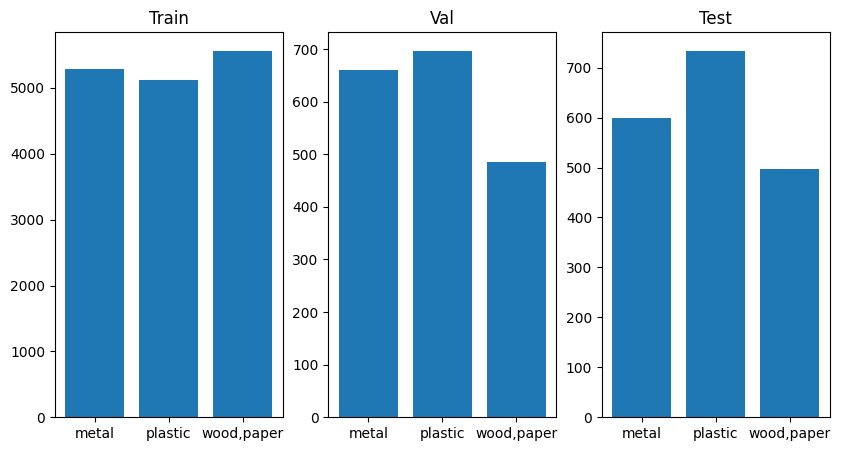

In [8]:
#plot frequency of each class in train/val/test
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(train_freq.keys(), train_freq.values())
plt.title("Train")
plt.subplot(1, 3, 2)
plt.bar(val_freq.keys(), val_freq.values())
plt.title("Val")
plt.subplot(1, 3, 3)
plt.bar(test_freq.keys(), test_freq.values())
plt.title("Test")
plt.show()

In [9]:
#calculate the factor to balance the dataset
ratio = 1/3
metal_factor = 1 / (train_freq["metal"]) * len(os.listdir(target_dir + "train")) * ratio
plastic_factor = 1 / (train_freq["plastic"]) * len(os.listdir(target_dir + "train")) * ratio
wood_paper_factor = 1 / (train_freq["wood,paper"]) * len(os.listdir(target_dir + "train")) * ratio
print("metal_factor: ", metal_factor)
print("plastic_factor: ", plastic_factor)
print("wood_paper_factor: ", wood_paper_factor)

metal_factor:  1.0067448310640443
plastic_factor:  1.0403882483225848
wood_paper_factor:  0.9564618517187686


In [10]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations[self.annotations["filename"] == img_name]["label"].values[0]
        y_label = [0.0, 0.0, 0.0]
        y_label[self.label[material_name]] = 1.0
        y_label = torch.tensor(y_label)
        path = img_name
        return (image, y_label, path)

In [11]:
material_label = {"metal": 0, "plastic": 1, "wood,paper": 2}

In [12]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.ToTensor(),
])

In [13]:
csv_file_label = "./labels_upsampled.csv"

In [14]:
Top4Dataset_train = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "train/", label=material_label, transform=data_transforms)
Top4Dataset_val = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "val/", label=material_label, transform=data_transforms)
Top4Dataset_test = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "test/", label=material_label, transform=data_transforms)

print(f"length of train dataset: {len(Top4Dataset_train)}")
print(f"length of val dataset: {len(Top4Dataset_val)}")
print(f"length of test dataset: {len(Top4Dataset_test)}")

length of train dataset: 15971
length of val dataset: 1843
length of test dataset: 1830


In [27]:
def load_data(data_dir):
    train_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "train/", label=material_label, transform=data_transforms)
    val_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "val/", label=material_label, transform=data_transforms)
    test_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "test/", label=material_label, transform=data_transforms)
    return train_dataset, val_dataset, test_dataset

In [28]:
batch_count = 8

In [29]:
DataLoader_train = DataLoader(dataset=Top4Dataset_train, batch_size=batch_count, shuffle=True)
DataLoader_val = DataLoader(dataset=Top4Dataset_val, batch_size=batch_count, shuffle=True)
DataLoader_test = DataLoader(dataset=Top4Dataset_test, batch_size=batch_count, shuffle=True)

In [30]:
label_list = ['metal', 'plastic', 'wood,paper']
DataLoader_train.dataset.__items_class__()

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

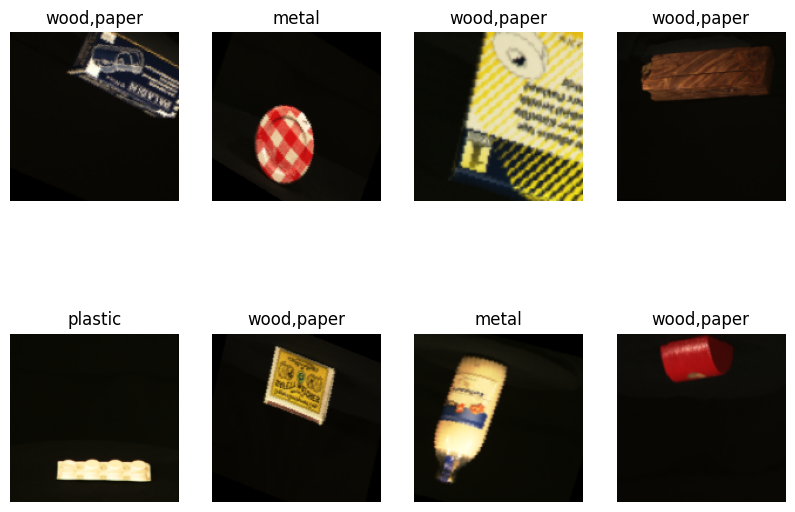

In [31]:
#show images
data = next(iter(DataLoader_train))
images, labels, path = data
plt.figure(figsize=(10, 15))
for i in range(batch_count):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(label_list[labels[i].argmax()])
    plt.axis("off")

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self, c1_out=16, c2_out=25, c1_kernel=3, c2_kernel=3, c1_stride=1, c2_stride=2, dropout=0.1):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, c1_out, kernel_size=c1_kernel, stride=c1_stride, padding= 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2),
            nn.Conv2d(c1_out, c2_out, kernel_size=c2_kernel, stride=c2_stride, padding= 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        logits = nn.functional.normalize(x)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        neural_size = logits.shape[1]
        logits = nn.Linear(neural_size, 3)(logits)
        logits = nn.LeakyReLU()(logits)
        return logits


Using cuda device


In [33]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y, z) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [34]:
def train_cifar(config, checkpoint_dir = None, data_dir = None):
    net = ConvNeuralNetwork(c1_out=config["c1_out"], c2_out=config["c2_out"], fc1_out=config["fc1_out"], c1_kernel=config["c1_kernel"], c2_kernel=config["c2_kernel"], c1_stride=config["c1_stride"], c2_stride=config["c2_stride"], c1_padding=config["c1_padding"], c2_padding=config["c2_padding"], c1_pool_kernel=config["c1_pool_kernel"], c2_pool_kernel=config["c2_pool_kernel"], dropout=config["dropout"])
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])
    if checkpoint_dir:
        checkpoint = torch.load(checkpoint_dir)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    train_dataset, val_dataset, test_dataset = load_data(data_dir)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, path = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 50 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
        avg_testloss = test(test_loader, net, criterion)
        if checkpoint_dir:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, path)
        tune.report(loss=avg_testloss, accuracy=avg_testloss)    
    print('Finished Training')


In [35]:
weight = [metal_factor, plastic_factor, wood_paper_factor]
DataLoader_train.dataset.label

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

In [36]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "momentum": tune.uniform(0.1, 0.9),
    "batch_size": tune.choice([4, 8, 16, 32, 64]),
    "epochs": 50,
    "c1_out": tune.choice([16, 32, 64]),
    "c2_out": tune.choice([16, 32, 64]),
    "c1_kernel": tune.choice([3, 5, 7]),
    "c2_kernel": tune.choice([3, 5, 7]),
    "c1_stride": tune.choice([1, 2, 3]),
    "c2_stride": tune.choice([1, 2, 3]),
    "c1_pool_kernel": tune.choice([2, 3, 4]),
    "c2_pool_kernel": tune.choice([2, 3, 4]),
    "dropout": tune.uniform(0.1, 0.5),
}

In [37]:
data_dir = "./trainvaltest/"
checkpoint_dir = "./checkpoint/"

In [39]:
config = {
    "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}
train_dataset, val_dataset, test_dataset = load_data(data_dir)
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_cifar, data_dir=data_dir),
    resources_per_trial={"cpu": 1, "gpu": 1},
    config=config,
    num_samples= 10,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

2023-01-03 19:14:24,658	INFO worker.py:1538 -- Started a local Ray instance.
c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\function_trainable.py:610: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  warnings.warn(
2023-01-03 19:14:34,168	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00000: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=10600, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet

== Status ==
Current time: 2023-01-03 19:14:28 (running for 00:00:00.23)
Memory usage on this node: 15.8/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00000 | RUNNING  | 127.0.0.1:10600 |           16 |   32 |   32 | 0.0324601   |
| train_cifar_76617_00001 | PENDING  |                 |            8 |    4 |  256 | 0.00996331  

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
train_cifar_76617_00000,2023-01-03_19-14-34,a34720cecbeb40839d03075fa8fa3525,DESKTOP-CU406LO,127.0.0.1,10600,1672769674,76617_00000
train_cifar_76617_00001,2023-01-03_19-14-40,92cf9cfa185c4d9f9229d31088906a0a,DESKTOP-CU406LO,127.0.0.1,15524,1672769680,76617_00001
train_cifar_76617_00002,2023-01-03_19-14-46,a742104c5bfc45adac186cee2f38f4a4,DESKTOP-CU406LO,127.0.0.1,31580,1672769686,76617_00002
train_cifar_76617_00003,2023-01-03_19-14-52,e7b35078dd8449639ba5640d30e2cade,DESKTOP-CU406LO,127.0.0.1,26164,1672769692,76617_00003
train_cifar_76617_00004,2023-01-03_19-14-58,1332c4ccf68141c99c76740065d8f09d,DESKTOP-CU406LO,127.0.0.1,28084,1672769698,76617_00004
train_cifar_76617_00005,2023-01-03_19-15-04,908ba5a1d45e40559a34d7604a699811,DESKTOP-CU406LO,127.0.0.1,9516,1672769704,76617_00005
train_cifar_76617_00006,2023-01-03_19-15-10,076b06c1e9d54d29b6c2c33cbd31f603,DESKTOP-CU406LO,127.0.0.1,26172,1672769710,76617_00006
train_cifar_76617_00007,2023-01-03_19-15-16,26dafd547ea640da84634170cf0d74c2,DESKTOP-CU406LO,127.0.0.1,32480,1672769716,76617_00007


== Status ==
Current time: 2023-01-03 19:14:34 (running for 00:00:05.55)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (1 ERROR, 9 PENDING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00001 | PENDING  |                 |            8 |    4 |  256 | 0.00996331  |
| train_cifar_76617_00002 | PENDING  |                 |            4 |    8 |   32 | 0.000196948 |
| tr

2023-01-03 19:14:40,174	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00001: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=15524, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "c:\Users\Frank\anaconda3\envs\torch\lib

== Status ==
Current time: 2023-01-03 19:14:39 (running for 00:00:11.34)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (1 ERROR, 8 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00001 | RUNNING  | 127.0.0.1:15524 |            8 |    4 |  256 | 0.00996331  |
| train_cifar_76617_00002 | PENDING  |                 |            4 |    8 |   32 | 0.0

2023-01-03 19:14:46,105	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00002: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=31580, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "c:\Users\Frank\anaconda3\envs\torch\lib

== Status ==
Current time: 2023-01-03 19:14:46 (running for 00:00:17.39)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (2 ERROR, 7 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00002 | RUNNING  | 127.0.0.1:31580 |            4 |    8 |   32 | 0.000196948 |
| train_cifar_76617_00003 | PENDING  |                 |            8 |   16 |   32 | 0.0

2023-01-03 19:14:52,510	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00003: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=26164, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "c:\Users\Frank\anaconda3\envs\torch\lib

== Status ==
Current time: 2023-01-03 19:14:52 (running for 00:00:23.43)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (3 ERROR, 6 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00003 | RUNNING  | 127.0.0.1:26164 |            8 |   16 |   32 | 0.0104382   |
| train_cifar_76617_00004 | PENDING  |                 |            8 |    4 |   32 | 0.0

2023-01-03 19:14:58,177	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00004: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=28084, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "c:\Users\Frank\anaconda3\envs\torch\lib

== Status ==
Current time: 2023-01-03 19:14:58 (running for 00:00:29.51)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (4 ERROR, 5 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00004 | RUNNING  | 127.0.0.1:28084 |            8 |    4 |   32 | 0.000256178 |
| train_cifar_76617_00005 | PENDING  |                 |           16 |  128 |  128 | 0.0

2023-01-03 19:15:04,326	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00005: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=9516, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\

== Status ==
Current time: 2023-01-03 19:15:04 (running for 00:00:35.57)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (5 ERROR, 4 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00005 | RUNNING  | 127.0.0.1:9516  |           16 |  128 |  128 | 0.00524377  |
| train_cifar_76617_00006 | PENDING  |                 |            8 |    4 |    8 | 0.0

2023-01-03 19:15:10,412	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00006: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=26172, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "c:\Users\Frank\anaconda3\envs\torch\lib

== Status ==
Current time: 2023-01-03 19:15:10 (running for 00:00:41.59)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (6 ERROR, 3 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00006 | RUNNING  | 127.0.0.1:26172 |            8 |    4 |    8 | 0.000105625 |
| train_cifar_76617_00007 | PENDING  |                 |            8 |   32 |   32 | 0.0

2023-01-03 19:15:16,808	ERROR trial_runner.py:1088 -- Trial train_cifar_76617_00007: Error processing event.
ray.exceptions.RayTaskError(KeyError): ray::ImplicitFunc.train() (pid=32480, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "c:\Users\Frank\anaconda3\envs\torch\lib

== Status ==
Current time: 2023-01-03 19:15:16 (running for 00:00:47.66)
Memory usage on this node: 16.1/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (7 ERROR, 2 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00007 | RUNNING  | 127.0.0.1:32480 |            8 |   32 |   32 | 0.00128966  |
| train_cifar_76617_00008 | PENDING  |                 |            4 |   16 |   64 | 0.0

2023-01-03 19:15:22,349	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2023-01-03 19:15:22 (running for 00:00:53.72)
Memory usage on this node: 16.0/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.16 GiB heap, 0.0/5.08 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_19-14-28
Number of trials: 10/10 (8 ERROR, 1 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_cifar_76617_00008 | RUNNING  | 127.0.0.1:27528 |            4 |   16 |   64 | 0.000294229 |
| train_cifar_76617_00009 | PENDING  |                 |            8 |   64 |   16 | 0.0

2023-01-03 19:15:22,959	ERROR tune.py:758 -- Trials did not complete: [train_cifar_76617_00000, train_cifar_76617_00001, train_cifar_76617_00002, train_cifar_76617_00003, train_cifar_76617_00004, train_cifar_76617_00005, train_cifar_76617_00006, train_cifar_76617_00007, train_cifar_76617_00008, train_cifar_76617_00009]
2023-01-03 19:15:22,960	INFO tune.py:762 -- Total run time: 54.38 seconds (54.10 seconds for the tuning loop).
2023-01-03 19:15:22,960	WARNING tune.py:768 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`
2023-01-03 19:15:22,971	WARNING experiment_analysis.py:627 -- Could not find best trial. Did you pass the correct `metric` parameter?


AttributeError: 'NoneType' object has no attribute 'config'